In [2]:
import math
import numpy as np
import os
import pandas as pd
import random
import sys
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

tissu = ['WholeBlood','Cells-Transformedfibroblasts','Muscle-Skeletal','Lung','Adipose-Subcutaneous','Artery-Tibial','Esophagus-Mucosa']
CHR = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,'X','Y']
Gene_table = pd.read_csv('/storage/szfeupe/Runs/GTEx_estr/FEATURES/Genes_only_table', sep='\t')
Motifs = pd.read_csv('/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed', sep='\t')

In [3]:
top10=[]
All_eSTRs=[]
for Tissue in tissu:
    print(Tissue)
    HERIT='/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/'+Tissue+'/HH/All_genesh2_gcta'
    CAUSE='/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/'+Tissue+'/HH/caviar.out'
    LR = '/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/'+Tissue+'/PQValues.txt'

    h2 = pd.read_csv(HERIT,sep='\t')
    h2['str.start']=h2['str_start'] ; del h2['str_start']
    print(max(h2['cis_str_h2']),'\t',max(h2['cis_snp_h2']))

    lr = pd.read_csv(LR,sep='\t')

    Cs=[]
    for i in CHR:
        C=pd.read_csv(CAUSE+str(i), sep='\t')
        Cs.append(C)
    causal=Cs[0]
    for i in range(1,24,1):
        causal=causal.append(Cs[i])   

    causal['best.str.start'] = causal['best.str.start'].astype(int)
    CA = causal.merge(h2, on='gene')
    del CA['chrom_y']
    #Master = CA.merge(lr, on=['gene','str.start'])
    CA.index = CA['gene']
    lr.index = lr['gene']
    Master = pd.concat( [lr, CA], axis=1)
    
    print(lr.shape, CA.shape, Master.shape)

    #CAVIAR causality score = product of posterior causal probability 
    #and the STR’s cis heritability fraction (h2_str/h2_all_cis)
    Master['causality.score'] = Master['best.str.score']*Master['cis_str_h2']/(Master['cis_str_h2']+Master['cis_snp_h2'])

    #Add gene names, remove duplicate columns and rearrange columns
    genes=Gene_table.loc[Gene_table['gene'].isin(list(Master.index))]
    genes=genes[['gene','chrom','gene.name']]
    genes.index=genes['gene']
    P = pd.concat( [genes,Master], axis=1)
    P['gene.id']=genes['gene']
    del Master['gene']
    P['chrom_x']=P['chrom']
    del P['chrom']
    Head=['gene.id','chrom_x','gene.name','str.id','best.str.start', 'best.str.score','causality.score','top.variant','top.variant.score', 'significant','p.wald', 'beta','qvalue','NTEST','beta.se', 'AD.pval','cis_str_h2', 'num_snps', 'cis_str_h2_pval', 'cis_str_h2_se','nsamp','cis_snp_h2','cis_snp_h2_se', 'logL']
    Master = P[Head]
    Master.columns=['gene','chrom','gene.name','str.id','best.str.start', 'best.str.score','causality.score','top.variant','top.variant.score', 'significant','p.wald', 'beta','qvalue','NTEST','beta.se', 'AD.pval','cis_str_h2', 'num_snps', 'cis_str_h2_pval', 'cis_str_h2_se','nsamp','cis_snp_h2','cis_snp_h2_se', 'logL']
    Master.to_csv('/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/'+Tissue+'/Master.table', sep='\t',  index=None)
    
    #sort by causality score and select top 10
    P = Master.sort_values('causality.score',ascending = False).head(11)
    top10.append(P)

    #Summary
    c=Master
    estrs = c.loc[c['qvalue']<0.1] 
    print(estrs.shape[0],' eSTRs')
    TOP1 = c.loc[c['top.variant']==c['str.id']]
    TOP2 = estrs.loc[estrs['top.variant']==estrs['str.id']]
    All_eSTRs.append(TOP2)
    print(TOP1.shape[0],' genes for which the top causal variant is the STRs,\n\t including ',TOP2.shape[0],' eSTRs (10% FDR)')
    print('The record (eSTR) with highest causality score is \n')
    print(TOP2.loc[TOP2['causality.score']==max(TOP2['causality.score'])][['str.id','best.str.score','qvalue','causality.score']])
    print(Master.loc[Master['cis_str_h2']>=1].shape, '----------------\n')

top10s = pd.concat(top10)
print('END!')



##   RUN The following
##python ~/projects/GTEX_eSTRs/gtex-estrs/Scripts/STRs-vs-SNPs_effects/merge_causality_scores.py /storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/ WholeBlood,Cells-Transformedfibroblasts,Muscle-Skeletal,Lung,Artery-Tibial,Adipose-Subcutaneous,Esophagus-Mucosa causality > Merged_Best_causality.Table
##   To merge n select best by tissue


WholeBlood
0.610076593476 	 11.655728
(14845, 11) (13283, 15) (14845, 26)
630  eSTRs
1127  genes for which the top causal variant is the STRs,
	 including  90  eSTRs (10% FDR)
The record (eSTR) with highest causality score is 

                        str.id  best.str.score    qvalue  causality.score
ENSG00000198286.5  STR_3062568        0.956243  0.007615         0.956205
(0, 24) ----------------

Cells-Transformedfibroblasts
0.617184643321 	 6.644152
(15362, 11) (13796, 15) (15362, 26)
955  eSTRs
1192  genes for which the top causal variant is the STRs,
	 including  151  eSTRs (10% FDR)
The record (eSTR) with highest causality score is 

                         str.id  best.str.score    qvalue  causality.score
ENSG00000160213.5  STR_45196326        0.941578  0.005047         0.941574
(0, 24) ----------------

Muscle-Skeletal
0.966222157156 	 2.117598
(15275, 11) (12637, 15) (15275, 26)
304  eSTRs
1112  genes for which the top causal variant is the STRs,
	 including  38  eSTRs (10% F

In [6]:
"""plt.plot(Master['best.str.score'],Master['top.variant.score'], 'g.')
plt.xlabel('best str score')
plt.ylabel('top variant score')
plt.show()

X=np.log10(Master['best.str.score'])*(-1)
plt.plot(X, Master['top.variant.score'], 'b.')
plt.xlabel('-Log10(best.str.score)')
plt.ylabel('Top variant score')
plt.show()
S=[]
ST = [list(All_eSTRs[i]["gene"]) for i in range(len(All_eSTRs))]
for i in range(len(ST)):
    S = S+ST[i]

dup=0; count=0

for G in set(S):
    if S.count(G)>1:
        dup=dup+1
        print(G, '-----',S.count(G))
    else:
        count=count+1
    
print  (count, '---', dup, '---', count+dup) #ENSG00000174106.2"""
Master.loc[Master["gene"]=='ENSG00000100852.8']

,gene,chrom,gene.name,str.id,best.str.start,best.str.score,causality.score,top.variant,top.variant.score,significant,...,beta.se,AD.pval,cis_str_h2,num_snps,cis_str_h2_pval,cis_str_h2_se,nsamp,cis_snp_h2,cis_snp_h2_se,logL
ENSG00000100852.8,ENSG00000100852.8,chr14,ARHGAP5,STR_32521434,32521434.0,0.979497,0.914729,STR_32521434,0.979497,1,...,0.094405,0.00002,0.216422,416.0,0.4221,0.089914,131.0,0.015324,0.065791,-36.207


/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


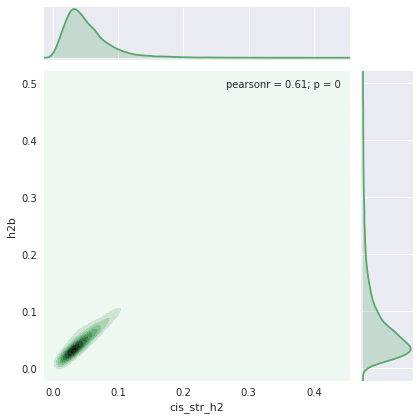

(16111, 25)  After restricting to h2b<=1  (14363, 25)


In [4]:
#Heat scatter plots showing the heritability of each eQTL 
#apportioned to the most significant STR in the cis window 
#x = axis h2_str y = the additive effect from the top 100 most significant SNVs 

Master['h2b']= Master["cis_snp_h2"] + Master["cis_str_h2"]
MM1 = Master.loc[Master['h2b']<=.5]
ESTR = Master.loc[Master['qvalue']<0.1]
#plt.scatter(ESTR['cis_str_h2'],ESTR['h2b'])
sns.jointplot(x="cis_str_h2", y="h2b", data=MM1, kind="kde", color="g")
plt.show()
print (Master.shape, ' After restricting to h2b<=1 ',MM1.shape)